In [1]:
import sys
sys.path.append('../')
from utilities import *
import utilities

# Loading the Dataset

In [3]:
# Define the transformations for training data
transform_training_data = Compose([
    ResizeWithPad(new_shape=(224, 224)),
    ToTensor(),
    CustomNormalize(),
])

# Define the transformations for validation data (no augmentation, only necessary processing)
transform_validation_data = Compose([
    ResizeWithPad(new_shape=(224, 224)),
    ToTensor(),
    CustomNormalize(),
])

train_loader, val_loader = get_train_and_validation_loader(transform_training_data, transform_validation_data, batch_size=32)

# Define the model

In [4]:
class MaskedAutoEncoder(nn.Module):
    def __init__(self):
        super(MaskedAutoEncoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # (64, 64, 64)
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (128, 32, 32)
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # (256, 16, 16)
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # (512, 8, 8)
            nn.ReLU(True)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # (256, 16, 16)
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # (128, 32, 32)
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (64, 64, 64)
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # (3, 128, 128)
            nn.Tanh()
        )

    def forward(self, x, mask_ratio=0.25, grid_size=16):
        # Apply grid masking
        batch_size, _, H, W = x.shape
        mask = self.create_grid_mask(batch_size, H, W, grid_size, mask_ratio).to(x.device)

        x_masked = x * mask

        # Encode
        encoded = self.encoder(x_masked)

        # Decode
        decoded = self.decoder(encoded)

        return decoded, mask, x_masked

    def create_grid_mask(self, batch_size, H, W, grid_size, mask_ratio):
        mask = torch.ones(batch_size, 1, H, W)
        num_blocks_H = H // grid_size
        num_blocks_W = W // grid_size
        total_blocks = num_blocks_H * num_blocks_W
        num_masked_blocks = int(mask_ratio * total_blocks)

        for i in range(batch_size):
            indices = torch.randperm(total_blocks)[:num_masked_blocks]
            for idx in indices:
                h = (idx // num_blocks_W) * grid_size
                w = (idx % num_blocks_W) * grid_size
                mask[i, 0, h:h+grid_size, w:w+grid_size] = 0

        return mask

In [5]:
# Instantiate the MaskedAutoEncoder
model = MaskedAutoEncoder().to(device)
# Loss function and optimizer
epochs=50
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train

In [6]:
train_losses, val_losses, train_mse_scores, val_mse_scores, train_mae_scores, val_mae_scores, train_r2_scores, val_r2_scores = mae_train(model, train_loader, val_loader, epochs, criterion, optimizer)

Epoch 1/2
Training: Loss: 0.5306 | MSE: 0.54 | MAE: 0.56 | R2: 0.46
Validation: Loss: 0.2633 | MSE: 0.26 | MAE: 0.38 | R2: 0.74
------------------------------------------------------------------------------------------------------------------
Epoch 2/2
Training: Loss: 0.2289 | MSE: 0.23 | MAE: 0.34 | R2: 0.77
Validation: Loss: 0.2030 | MSE: 0.20 | MAE: 0.31 | R2: 0.80
------------------------------------------------------------------------------------------------------------------


# Save and Load the model

In [ ]:
save_model(model, './models/mae-grid-masking.pth')

In [ ]:
model = MaskedAutoEncoder().to(device)
load_model(model, './models/mae-grid-masking.pth')

# Plot Metrics

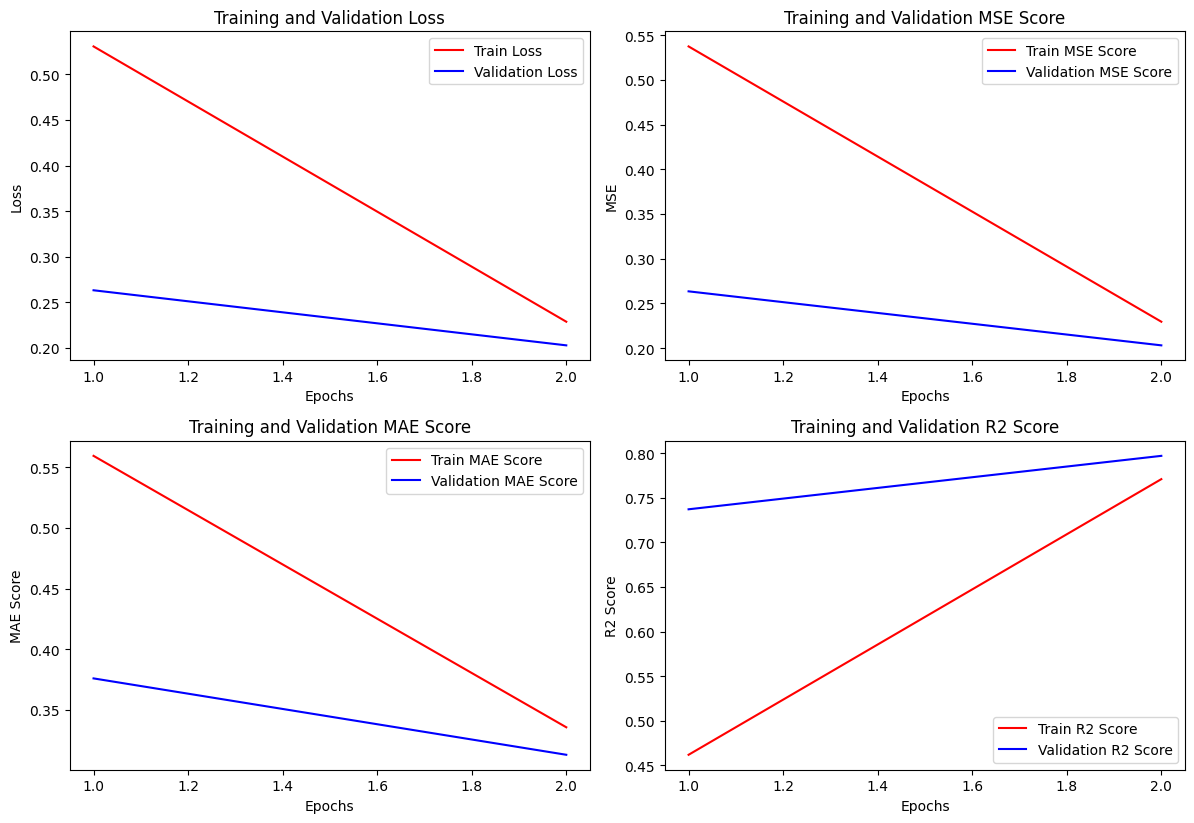

In [7]:
mae_plot_metrics(train_losses, val_losses, train_mse_scores, val_mse_scores, train_mae_scores, val_mae_scores, train_r2_scores, val_r2_scores)

# Plot Reconstructed Image

In [8]:
mae_plot_masking_details(model, val_loader, num_images=10)

Output hidden; open in https://colab.research.google.com to view.